based on https://www.kaggle.com/tigurius/recuplots-and-cnns-for-time-series-classification

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.spatial.distance import pdist, squareform #scipy spatial distance
import sklearn as sk
import sklearn.metrics.pairwise
import matplotlib.pyplot as plt
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, LeakyReLU
from keras import metrics
from keras import backend as K
import time
from skimage.transform import resize

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
#modified from https://stackoverflow.com/questions/33650371/recurrence-plot-in-python
def recurrence_plot(s, eps=None, steps=None):
    if eps==None: eps=0.1
    if steps==None: steps=10
    d = sk.metrics.pairwise.pairwise_distances(s)
    d = np.floor(d / eps)
    d[d > steps] = steps
    #Z = squareform(d)
    return d

In [3]:
import DataProcessCNN as DP

In [ ]:
#for subj_n in range(1,10):
    #load the data
#    subj_filename='C:/Users/lt/Desktop/DSW2018/PAMAP2_Dataset/Protocol/subject10'+str(subj_n)+'.dat'
#    dp=DP.dataprocess(subj_filename)
#    np.save('data'+str(subj_n)+'.npy', (DP.col_sublabels,dp.data_segmented))

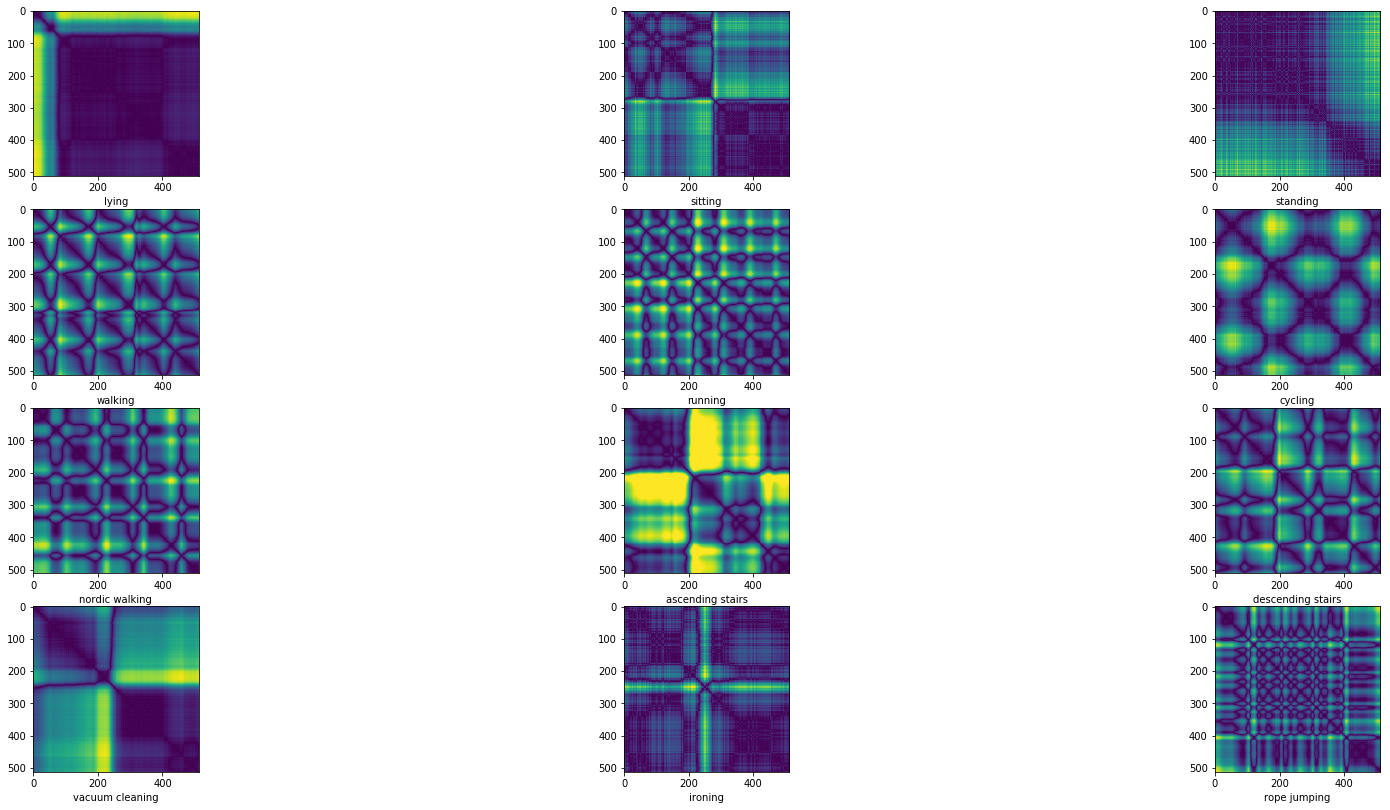

In [43]:
datalabels=[]
for i in range(1,10):
    feature_names,datalabelsi=np.load('data'+str(i)+'.npy')
    datalabels.append(datalabelsi)

datalabels=np.vstack(datalabels)

act_list=np.unique(datalabels[:,0,1])

data_byact=[datalabels[datalabels[:,0,1]==x] for x in act_list]

traindata=[x[:,:,2:] for x in data_byact]
trainlabel=[x[:,:,1] for x in data_byact]

fig = plt.figure(figsize=(30,14))
for i in range(12):
    ax = fig.add_subplot(4, 3, i+1)
    ax.imshow(recurrence_plot(traindata[i][0,:,29,None],steps=1000))
    ax.set_xlabel(DP.activity_dict[act_list[i]])

In [44]:
feat=(DP.col_sublabels.index('chest_acc16g_z'),DP.col_sublabels.index('ankle_gyro_z'),DP.col_sublabels.index('hand_acc16g_y'))

In [78]:
feat=range(31)

In [80]:
# convert folders to class labels
#pre allocate arrays
x_train = np.zeros((3330,len(feat)+1,32,32))
y_train = np.zeros(3330)

start = time.time()
c=0
for i in range(12):    
    print("Processing set " + str(i))
    for j in range(len(trainlabel[i])):
        dat = recurrence_plot(traindata[i][j], steps=1000)
        dat = resize(dat, (32,32),mode='constant')
        x_train[c,0,:,:] = dat
        y_train[c] = i
        for k in range(len(feat)):
            dat = recurrence_plot(traindata[i][j,:,feat[k],None], steps=1000)
            dat = resize(dat, (32,32),mode='constant')
            x_train[c,k+1,:,:] = dat
        c+=1
end = time.time()
print('Elapsed time:')
print(end - start)

Processing set 0


c:\programdata\miniconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Processing set 1
Processing set 2
Processing set 3
Processing set 4
Processing set 5
Processing set 6
Processing set 7
Processing set 8
Processing set 9
Processing set 10
Processing set 11
Elapsed time:
716.8731327056885


In [81]:
x_train.shape

(3330, 32, 32, 32)

In [82]:
y_train.shape

(3330,)

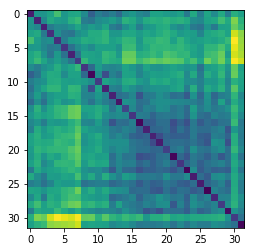

In [50]:
plt.imshow(x_train[560,0])

In [87]:
model = Sequential()
 
model.add(Convolution2D(32, (3, 3), activation='relu', input_shape=(32,32,32), data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Convolution2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25)) 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(LeakyReLU(alpha=0.03))
model.add(Dropout(0.5))
model.add(Dense(12, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [84]:
#reshape to include depth
#X_train = x_train[:,None]
X_train = x_train
#convert to float32 and normalize to [0,1]
X_train = X_train.astype('float32')
X_train /= np.amax(X_train)
# convert labels to class matrix, one-hot-encoding
Y_train = np_utils.to_categorical(y_train,12)
# split in train and test set
X_train, x_test, Y_train, y_test = train_test_split(X_train, Y_train, test_size=0.1)

In [85]:
np.save('CNNdata.npy', (X_train, x_test, Y_train, y_test))

In [88]:
model.fit(X_train, Y_train, epochs=200, batch_size=16,shuffle=True)

Epoch 1/200
2997/2997 [==============================] - 3s 974us/step - loss: 1.7162 - acc: 0.3861
Epoch 2/200
2997/2997 [==============================] - 2s 784us/step - loss: 0.9027 - acc: 0.6320
Epoch 3/200
2997/2997 [==============================] - 2s 784us/step - loss: 0.7019 - acc: 0.6994
Epoch 4/200
2997/2997 [==============================] - 2s 787us/step - loss: 0.6268 - acc: 0.7354
Epoch 5/200
2997/2997 [==============================] - 2s 791us/step - loss: 0.6016 - acc: 0.7598
Epoch 6/200
2997/2997 [==============================] - 2s 787us/step - loss: 0.5412 - acc: 0.7688
Epoch 7/200
2997/2997 [==============================] - 2s 791us/step - loss: 0.4938 - acc: 0.7831
Epoch 8/200
2997/2997 [==============================] - 3s 835us/step - loss: 0.4583 - acc: 0.8061
Epoch 9/200
2997/2997 [==============================] - 3s 835us/step - loss: 0.4535 - acc: 0.8198
Epoch 10/200
2997/2997 [==============================] - 2s 826us/step - loss: 0.4084 - acc: 0.8292

In [89]:
predictions= model.predict(x_test)

rounded = [np.argmax(x) for x in predictions]

Y_test=np.array([np.argmax(x) for x in y_test])

np.sum(np.array(rounded)==Y_test)/len(Y_test)

0.8858858858858859

In [91]:
import os
save_name = 'model.h5'
model.save(os.path.join('C:/Users/lt/Desktop/DSW2018/CNN', save_name))